In [1]:
%pip install requests_cache retry_requests

In [2]:
%pip install openmeteo-requests

In [3]:
!pip install pandas geopandas requests shapely fiona

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.2/17.2 MB 31.7 MB/s eta 0:00:00


In [4]:
!pip install pandas openmeteo-requests requests_cache retry_requests openpyxl

In [3]:
import openmeteo_requests
import requests_cache
import pandas as pd
from retry_requests import retry
import time
import sys

def fetch_all_weather_data(provinces_list):
    """
    Tải TẤT CẢ dữ liệu thời tiết (8 biến) cho 13 tỉnh
    từ 1994-01-01 đến 2025-06-30.
    """

    print("Đang cài đặt API client...")
    cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
    retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
    openmeteo = openmeteo_requests.Client(session = retry_session)

    # --- Mã GSO (Tổng cục Thống kê) ---
    gso_codes = {
        "Can Tho": "92", "An Giang": "87", "Bac Lieu": "95", "Ben Tre": "83",
        "Ca Mau": "96", "Dong Thap": "86", "Hau Giang": "93", "Kien Giang": "88",
        "Long An": "80", "Soc Trang": "94", "Tien Giang": "82", "Tra Vinh": "84",
        "Vinh Long": "89"
    }

    # Các thông số chung
    url = "https://archive-api.open-meteo.com/v1/archive"
    start_date = "1994-01-01"
    end_date = "2025-06-30"

    # --- GỘP TẤT CẢ BIẾN SỐ BẠN CẦN ---
    daily_vars = [
        "weather_code",             # (0)
        "temperature_2m_max",       # (1)
        "temperature_2m_min",       # (2)
        "temperature_2m_mean",      # (3)
        "precipitation_sum",        # (4)
        "rain_sum",                 # (5)
        "relative_humidity_2m_mean",# (6)
        "et0_fao_evapotranspiration" # (7)
    ]

    all_province_data = []

    print(f"Bắt đầu tải dữ liệu tổng hợp cho {len(provinces_list)} tỉnh...")

    for i, province in enumerate(provinces_list):
        name = province["name"]
        lat = province["latitude"]
        lon = province["longitude"]
        code = gso_codes.get(name, None) # Lấy mã GSO

        print(f"\n({i+1}/{len(provinces_list)}) Đang tải dữ liệu cho: {name} (Mã: {code})")

        params = {
            "latitude": lat,
            "longitude": lon,
            "start_date": start_date,
            "end_date": end_date,
            "daily": daily_vars,
            "timezone": "Asia/Bangkok"
        }

        try:
            # Gọi API
            responses = openmeteo.weather_api(url, params=params)
            response = responses[0]

            daily = response.Daily()

            date_range = pd.date_range(
                start = pd.to_datetime(daily.Time(), unit = "s", utc = True),
                end = pd.to_datetime(daily.TimeEnd(), unit = "s", utc = True),
                freq = pd.Timedelta(seconds = daily.Interval()),
                inclusive = "left"
            )

            daily_data = {
                "date": date_range,
                "weather_code": daily.Variables(0).ValuesAsNumpy(),
                "max_temp": daily.Variables(1).ValuesAsNumpy(),
                "min_temp": daily.Variables(2).ValuesAsNumpy(),
                "mean_temp": daily.Variables(3).ValuesAsNumpy(),
                "precipitation_sum": daily.Variables(4).ValuesAsNumpy(),
                "rain_sum": daily.Variables(5).ValuesAsNumpy(),
                "humidity_mean": daily.Variables(6).ValuesAsNumpy(),
                "et0_mm": daily.Variables(7).ValuesAsNumpy(),
            }

            daily_df = pd.DataFrame(data = daily_data)
            daily_df["province"] = name
            daily_df["province_code"] = code

            all_province_data.append(daily_df)
            print(f"Đã tải xong {name}. (Tổng số {len(daily_df)} ngày)")

        except Exception as e:
            print(f"!!! LỖI khi tải dữ liệu cho {name}: {e}")
            print("Đang tạm dừng 60 giây do có lỗi...")
            time.sleep(100)

        # Nghỉ 60 giây để tránh vượt giới hạn API
        if i < len(provinces_list) - 1: # Không cần chờ sau khi xong tỉnh cuối cùng
            print("Đang nghỉ 100 giây để tránh vượt giới hạn API...")
            time.sleep(100)

    # Gộp tất cả DataFrame lại
    if not all_province_data:
        print("Không tải được bất kỳ dữ liệu nào.")
        return None

    print(f"\nĐang gộp dữ liệu {len(all_province_data)} tỉnh...")
    final_df = pd.concat(all_province_data, ignore_index=True)

    # Định dạng lại ngày cho sạch
    final_df['date'] = final_df['date'].dt.tz_convert('Asia/Bangkok').dt.date

    # Sắp xếp lại cột cho dễ nhìn
    cols_order = [
        'province', 'province_code', 'date',
        'weather_code', 'max_temp', 'min_temp', 'mean_temp',
        'precipitation_sum', 'rain_sum', 'humidity_mean', 'et0_mm'
    ]
    final_df = final_df[cols_order]

    return final_df

# --- Thực thi code ---
if __name__ == "__main__":

    if 'openmeteo_requests' not in sys.modules:
        print("Lỗi: Các thư viện cần thiết chưa được cài đặt.")
        print("Vui lòng chạy: !pip install pandas openmeteo-requests requests_cache retry_requests openpyxl")
    else:
        provinces_input = [
            {"name": "Can Tho", "latitude": 10.0452, "longitude": 105.7469},
            {"name": "An Giang", "latitude": 10.3800, "longitude": 105.4200},
            {"name": "Bac Lieu", "latitude": 9.2941, "longitude": 105.7256},
            {"name": "Ben Tre", "latitude": 10.2400, "longitude": 106.3700},
            {"name": "Ca Mau", "latitude": 9.1769, "longitude": 105.1517},
            {"name": "Dong Thap", "latitude": 10.4570, "longitude": 105.6330},
            {"name": "Hau Giang", "latitude": 9.7760, "longitude": 105.4670},
            {"name": "Kien Giang", "latitude": 10.0090, "longitude": 105.0840},
            {"name": "Long An", "latitude": 10.6667, "longitude": 106.3333},
            {"name": "Soc Trang", "latitude": 9.6010, "longitude": 105.9720},
            {"name": "Tien Giang", "latitude": 10.3500, "longitude": 106.3500},
            {"name": "Tra Vinh", "latitude": 9.9400, "longitude": 106.3400},
            {"name": "Vinh Long", "latitude": 10.2500, "longitude": 105.9667}
        ]

        # Chạy hàm
        combined_data = fetch_all_weather_data(provinces_input)

        if combined_data is not None:
            # Lưu ra Excel
            output_file = "DBSCL_weather_1994_2025.xlsx" # Tên tệp mới
            try:
                combined_data.to_excel(output_file, index=False, engine='openpyxl')
                print(f"\n--- THÀNH CÔNG ---")

                # *** (SỬA LỖI NAMEERROR TẠI ĐÂY) ***
                # Sử dụng 'combined_data' để đếm số tỉnh duy nhất đã được xử lý
                num_provinces_processed = combined_data['province'].nunique()
                print(f"Đã lưu toàn bộ dữ liệu (8 biến, {num_provinces_processed} tỉnh) vào tệp: {output_file}")

                print(f"Tổng số dòng: {len(combined_data)}")
                print("\nXem trước 5 dòng đầu tiên:")
                print(combined_data.head())
            except Exception as e:
                print(f"\nLỗi khi lưu Excel: {e}")
                print("Hãy đảm bảo bạn đã cài 'openpyxl'.")

Đang cài đặt API client...
Bắt đầu tải dữ liệu tổng hợp cho 13 tỉnh...

(1/13) Đang tải dữ liệu cho: Can Tho (Mã: 92)
Đã tải xong Can Tho. (Tổng số 11504 ngày)
Đang nghỉ 100 giây để tránh vượt giới hạn API...

(2/13) Đang tải dữ liệu cho: An Giang (Mã: 87)
Đã tải xong An Giang. (Tổng số 11504 ngày)
Đang nghỉ 100 giây để tránh vượt giới hạn API...

(3/13) Đang tải dữ liệu cho: Bac Lieu (Mã: 95)
Đã tải xong Bac Lieu. (Tổng số 11504 ngày)
Đang nghỉ 100 giây để tránh vượt giới hạn API...

(4/13) Đang tải dữ liệu cho: Ben Tre (Mã: 83)
Đã tải xong Ben Tre. (Tổng số 11504 ngày)
Đang nghỉ 100 giây để tránh vượt giới hạn API...

(5/13) Đang tải dữ liệu cho: Ca Mau (Mã: 96)
Đã tải xong Ca Mau. (Tổng số 11504 ngày)
Đang nghỉ 100 giây để tránh vượt giới hạn API...

(6/13) Đang tải dữ liệu cho: Dong Thap (Mã: 86)
Đã tải xong Dong Thap. (Tổng số 11504 ngày)
Đang nghỉ 100 giây để tránh vượt giới hạn API...

(7/13) Đang tải dữ liệu cho: Hau Giang (Mã: 93)
Đã tải xong Hau Giang. (Tổng số 11504 ngày)
Đa

In [6]:
import pandas as pd

# --- 1. Định nghĩa ngày nắng (như code của bạn) ---
# [Suy luận] Dựa trên mã WMO, "nắng" là các mã:
# 0: Trời quang, 1: Trời trong, 2: Ít mây
SUNNY_CODES = [0, 1, 2]

# --- 2. Tải tệp dữ liệu (ĐÃ THAY ĐỔI) ---
# [Suy luận] Đọc từ tệp đầy đủ (8 biến) mà chúng ta đã tạo ở bước trước
file_path = 'DBSCL_weather_1994_2025.xlsx'
try:
    df = pd.read_excel(file_path, engine='openpyxl')
except FileNotFoundError:
    print(f"Lỗi: Không tìm thấy tệp {file_path}")
    print("Vui lòng đảm bảo tệp này (từ bước trước) nằm trong cùng thư mục.")
    raise SystemExit() # Dừng code nếu lỗi
except Exception as e:
    print(f"Lỗi khi đọc tệp: {e}")
    raise SystemExit() # Dừng code nếu lỗi

# --- 3. Chuyển đổi cột 'date' ---
# Tệp Excel này đã có định dạng ngày tháng chuẩn,
# nhưng read_excel có thể đọc nó dưới dạng 'timestamp',
# chúng ta chuyển đổi nó về 'datetime' cho chắc chắn.
df['date'] = pd.to_datetime(df['date'])

# --- 4. Tạo cột xác định ngày nắng (như code của bạn) ---
# Kết quả là một cột boolean (True/False)
df['is_sunny'] = df['weather_code'].isin(SUNNY_CODES)

# --- 5. Trích xuất tháng (month) và năm (year) (như code của bạn) ---
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

# --- 6. Định nghĩa hàm để gán vụ (Sử dụng hàm CỦA BẠN) ---
def assign_seasons(row):
    month = row['month']
    year = row['year']
    seasons = []

    # Vụ Đông Xuân (winter_spring)
    if month in [1, 2, 3, 4]:
        seasons.append({'season': 'winter_spring', 'year': year})
    if month in [11, 12]:
        seasons.append({'season': 'winter_spring', 'year': year + 1})

    # Vụ Hè Thu (summer_autumn)
    if month in [4, 5, 6, 7, 8]:
        seasons.append({'season': 'summer_autumn', 'year': year})

    # Vụ mùa (main_season)
    if month in [5, 6, 7, 8, 9, 10, 11]:
        seasons.append({'season': 'main_season', 'year': year})

    return seasons

# --- 7. Áp dụng hàm, explode và tách cột (như code của bạn) ---
df['seasons'] = df.apply(assign_seasons, axis=1)
df_exploded = df.explode('seasons').reset_index(drop=True)

# Tách cột 'seasons'
df_exploded = df_exploded.dropna(subset=['seasons']) # Đảm bảo không có lỗi
df_exploded['season'] = df_exploded['seasons'].apply(lambda x: x['season'])
df_exploded['year'] = df_exploded['seasons'].apply(lambda x: x['year'])

# --- 8. (CẬP NHẬT) Thực hiện nhóm và tổng hợp TẤT CẢ ---
# Gộp cả quy tắc thời tiết, ngày nắng, độ ẩm, và ET0
print("Đang thực hiện nhóm và tổng hợp dữ liệu...")
summary_df = df_exploded.groupby(
    ['province', 'province_code', 'year', 'season'] # Thêm 'province_code' vào nhóm
).agg(
    # Các cột thời tiết (từ code của bạn)
    max_temp=('max_temp', 'mean'),
    min_temp=('min_temp', 'mean'),
    mean_temp=('mean_temp', 'mean'),
    total_precipitation=('precipitation_sum', 'sum'),
    total_rain=('rain_sum', 'sum'),

    # (MỚI) Các cột bạn yêu cầu thêm
    avg_humidity=('humidity_mean', 'mean'), # Lấy trung bình
    total_et0=('et0_mm', 'sum'),          # Lấy tổng

    # Các cột ngày nắng (từ code của bạn)
    sunny_day=('is_sunny', 'sum'),
    total_day=('date', 'count') # Đếm tổng số ngày
).reset_index()

# --- 9. (MỚI) Tính tỷ lệ ngày nắng (như code của bạn) ---
summary_df['sunny_day_rate'] = (summary_df['sunny_day'] / summary_df['total_day']) * 100

# --- 10. Sắp xếp và Lưu kết quả (như code của bạn) ---
summary_df = summary_df.sort_values(by=['province', 'year', 'season'])

# (THAY ĐỔI) Đặt tên tệp đầu ra mới
output_file = 'DBSCL_weather_summary_by_season_1994_2025.xlsx'
summary_df.to_excel(output_file, index=False, engine='openpyxl')

print(f"Đã tổng hợp xong! Kết quả được lưu tại: {output_file}")
print("\nXem trước 15 dòng kết quả tổng hợp:")
print(summary_df.head(15))

Đang thực hiện nhóm và tổng hợp dữ liệu...
Đã tổng hợp xong! Kết quả được lưu tại: DBSCL_weather_summary_by_season_1994_2025.xlsx

Xem trước 15 dòng kết quả tổng hợp:
    province  province_code  year         season   max_temp   min_temp  \
0   An Giang             87  1994    main_season  30.179122  24.273982   
1   An Giang             87  1994  summer_autumn  30.762674  24.810713   
2   An Giang             87  1994  winter_spring  32.135501  23.348001   
3   An Giang             87  1995    main_season  30.925150  24.692440   
4   An Giang             87  1995  summer_autumn  32.255157  25.245680   
5   An Giang             87  1995  winter_spring  32.141730  23.182061   
6   An Giang             87  1996    main_season  30.353187  24.381225   
7   An Giang             87  1996  summer_autumn  31.087837  24.726726   
8   An Giang             87  1996  winter_spring  31.166022  22.962451   
9   An Giang             87  1997    main_season  30.653655  24.592673   
10  An Giang       

In [ ]:
import pandas as pd
import numpy as np

# --- 1. Chuẩn bị (Ánh xạ tháng) ---
month_map = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4,
    'May': 5, 'June': 6, 'July': 7, 'August': 8,
    'September': 9, 'October': 10, 'November': 11, 'December': 12
}

# --- 2. Định nghĩa hàm gán Vụ (Theo logic của bạn) ---
# Hàm này sẽ gán một tháng/năm cụ thể vào các vụ tương ứng
def assign_seasons(row):
    month = row['month']
    year = row['Year']
    seasons_list = []

    # Vụ Đông Xuân
    if month in [1, 2, 3, 4]:
        seasons_list.append({'season': 'winter_spring', 'season_year': year}) # Key là 'season_year'
    if month in [11, 12]:
        seasons_list.append({'season': 'winter_spring', 'season_year': year + 1})

    # Vụ Hè Thu
    if month in [4, 5, 6, 7, 8]:
        seasons_list.append({'season': 'summer_autumn', 'season_year': year})

    # Vụ mùa
    if month in [5, 6, 7, 8, 9, 10, 11]:
        seasons_list.append({'season': 'main_season', 'season_year': year})

    return seasons_list

# --- 3. Tải và Xử lý dữ liệu ---
file_path = 'FAOSTAT_data_en_10-21-2025(2).csv'
try:
    df = pd.read_csv(file_path)
except FileNotFoundError:
    print(f"Lỗi: Không tìm thấy tệp {file_path}")
    exit()

print(f"Tải thành công tệp: {file_path}")

df = df[['Year', 'Months', 'Unit', 'Value']]
df['price_vnd_kg'] = df['Value'] / 1000

# --- 4. Xử lý logic "Annual" và "Monthly" ---
monthly_years = df[df['Months'] != 'Annual value']['Year'].unique()
annual_only_df = df[
    (df['Months'] == 'Annual value') &
    (~df['Year'].isin(monthly_years))
]
monthly_df = df[df['Year'].isin(monthly_years) & (df['Months'] != 'Annual value')].copy() # Thêm .copy()

print(f"Tìm thấy {len(annual_only_df)} dòng dữ liệu (theo Năm).")
print(f"Tìm thấy {len(monthly_df)} dòng dữ liệu (theo Tháng).")

all_results = []

# --- 4a. Xử lý nhóm "Annual" ---
if not annual_only_df.empty:
    seasons_to_add = ['winter_spring', 'summer_autumn', 'main_season']
    annual_results = annual_only_df.loc[annual_only_df.index.repeat(3)].copy()
    annual_results['season'] = seasons_to_add * len(annual_only_df)
    annual_results = annual_results.rename(columns={'Year': 'season_year'})
    all_results.append(annual_results[['season_year', 'season', 'price_vnd_kg']])
    print("Đã xử lý dữ liệu 'Annual'.")

# --- 4b. Xử lý nhóm "Monthly" ---
if not monthly_df.empty:

    # (SỬA LỖI CẢNH BÁO) Sử dụng .loc để gán giá trị, tránh SettingWithCopyWarning
    monthly_df.loc[:, 'month'] = monthly_df['Months'].map(month_map)

    monthly_df = monthly_df.dropna(subset=['month'])
    monthly_df['month'] = monthly_df['month'].astype(int)

    monthly_df['seasons'] = monthly_df.apply(assign_seasons, axis=1)

    exploded_df = monthly_df.explode('seasons').dropna(subset=['seasons'])

    # *** (SỬA LỖI KEYERROR TẠI ĐÂY) ***
    # Key (khóa) trong dictionary là 'season_year', không phải 'year'
    exploded_df['season'] = exploded_df['seasons'].apply(lambda x: x['season'])
    exploded_df['season_year'] = exploded_df['seasons'].apply(lambda x: x['season_year']) # <-- Sửa từ 'year' thành 'season_year'

    # Nhóm theo Năm Vụ, Vụ và tính trung bình giá
    monthly_results = exploded_df.groupby(
        ['season_year', 'season']
    ).agg(
        price_vnd_kg=('price_vnd_kg', 'mean')
    ).reset_index()

    all_results.append(monthly_results)
    print("Đã xử lý và tổng hợp dữ liệu 'Monthly'.")

# --- 5. Kết hợp và Lưu ---
if not all_results:
    print("Lỗi: Không có dữ liệu nào để xử lý.")
else:
    final_df = pd.concat(all_results, ignore_index=True)
    final_df = final_df.rename(columns={'season_year': 'Year'})
    final_df['price_vnd_kg'] = final_df['price_vnd_kg'].round(2)
    final_df = final_df.sort_values(by=['Year', 'season'])

    output_file = "FAOSTAT_price_summary_by_season.xlsx"
    final_df.to_excel(output_file, index=False, engine='openpyxl')

    print(f"\n--- HOÀN THÀNH ---")
    print(f"Đã lưu kết quả tổng hợp vào tệp: {output_file}")

    print("\nXem trước 15 dòng đầu tiên của kết quả:")
    print(final_df.head(15))

    print("\nXem 15 dòng cuối cùng của kết quả (để thấy dữ liệu theo tháng):")
    print(final_df.tail(15))

Tải thành công tệp: FAOSTAT_data_en_10-21-2025(2).csv
Tìm thấy 20 dòng dữ liệu (theo Năm).
Tìm thấy 148 dòng dữ liệu (theo Tháng).
Đã xử lý dữ liệu 'Annual'.
Đã xử lý và tổng hợp dữ liệu 'Monthly'.

--- HOÀN THÀNH ---
Đã lưu kết quả tổng hợp vào tệp: FAOSTAT_price_summary_by_season.xlsx

Xem trước 15 dòng đầu tiên của kết quả:
    Year         season  price_vnd_kg
2   1991    main_season        895.93
1   1991  summer_autumn        895.93
0   1991  winter_spring        895.93
5   1992    main_season        972.77
4   1992  summer_autumn        972.77
3   1992  winter_spring        972.77
8   1993    main_season        949.04
7   1993  summer_autumn        949.04
6   1993  winter_spring        949.04
11  1994    main_season       1083.51
10  1994  summer_autumn       1083.51
9   1994  winter_spring       1083.51
14  1995    main_season       1479.01
13  1995  summer_autumn       1479.01
12  1995  winter_spring       1479.01

Xem 15 dòng cuối cùng của kết quả (để thấy dữ liệu theo tháng)

In [ ]:
import pandas as pd

# --- File Paths ---
price_file = 'CMO-Historical-Data-Monthly(1).csv'
exchange_rate_file = 'dataset_2025-10-21T08_37_23.802192280Z_DEFAULT_INTEGRATION_IMF.STA_ER_4.0.1.csv'
output_file = 'Urea_Price_VND_kg_Monthly.xlsx'

try:
    # --- 1. Load and Process Price Data (World Bank) ---
    print(f"Đang đọc file giá: {price_file}")
    # Header is on the 5th row (index 4) based on the file structure
    df_prices = pd.read_csv(price_file, header=4)

    # Find the Urea column (case-insensitive search)
    urea_col_name = None
    for col in df_prices.columns:
        if 'urea' in col.lower():
            urea_col_name = col
            break

    if urea_col_name is None:
        raise ValueError("Không tìm thấy cột 'Urea' trong file giá.")

    # Select and rename columns
    df_prices = df_prices.iloc[:, [0, df_prices.columns.get_loc(urea_col_name)]].copy()
    df_prices.columns = ['Month', 'Urea_USD_mt']

    # Convert Urea price to numeric, coerce errors to NaN
    df_prices['Urea_USD_mt'] = pd.to_numeric(df_prices['Urea_USD_mt'], errors='coerce')
    print(f"Xử lý xong file giá. Tìm thấy cột: '{urea_col_name}'")

    # --- 2. Load and Process Exchange Rate Data (IMF) ---
    print(f"Đang đọc file tỉ giá: {exchange_rate_file}")
    df_exchange = pd.read_csv(exchange_rate_file)

    # Filter for 'Period average'
    # Assuming the column name is 'TYPE_OF_TRANSFORMATION', adjust if different
    transform_col = 'TYPE_OF_TRANSFORMATION' # Check exact name if error occurs
    if transform_col not in df_exchange.columns:
         raise ValueError(f"Không tìm thấy cột '{transform_col}' trong file tỉ giá.")

    df_exchange_avg = df_exchange[df_exchange[transform_col] == 'Period average'].copy()

    if df_exchange_avg.empty:
         raise ValueError("Không tìm thấy dòng nào có 'Period average' trong file tỉ giá.")

    # Melt/Unpivot the dataframe from wide to long format
    # Identify columns that are NOT month columns (id_vars)
    month_cols = [col for col in df_exchange_avg.columns if '-M' in col]
    id_cols = [col for col in df_exchange_avg.columns if col not in month_cols]

    df_exchange_long = pd.melt(df_exchange_avg,
                               id_vars=id_cols,
                               value_vars=month_cols,
                               var_name='Month_Raw',
                               value_name='USD_VND')

    # Clean the Month format (1995-M01 -> 1995M01)
    df_exchange_long['Month'] = df_exchange_long['Month_Raw'].str.replace('-', '')

    # Convert exchange rate to numeric, coerce errors to NaN
    df_exchange_long['USD_VND'] = pd.to_numeric(df_exchange_long['USD_VND'], errors='coerce')

    # Select only necessary columns
    df_exchange_final = df_exchange_long[['Month', 'USD_VND']].copy()
    print("Xử lý xong file tỉ giá.")

    # --- 3. Merge DataFrames ---
    print("Đang gộp dữ liệu giá và tỉ giá...")
    df_merged = pd.merge(df_prices, df_exchange_final, on='Month', how='inner')

    # Drop rows where either price or exchange rate is missing
    rows_before_drop = len(df_merged)
    df_merged.dropna(subset=['Urea_USD_mt', 'USD_VND'], inplace=True)
    rows_after_drop = len(df_merged)
    if rows_before_drop > rows_after_drop:
        print(f"Đã loại bỏ {rows_before_drop - rows_after_drop} dòng do thiếu giá hoặc tỉ giá.")


    # --- 4. Calculate VND/kg Price ---
    print("Đang tính toán giá VND/kg...")
    # USD/mt * VND/USD = VND/mt
    df_merged['Urea_VND_mt'] = df_merged['Urea_USD_mt'] * df_merged['USD_VND']
    # VND/mt / 1000 = VND/kg
    df_merged['Urea_VND_kg'] = df_merged['Urea_VND_mt'] / 1000

    # Round the final price
    df_merged['Urea_VND_kg'] = df_merged['Urea_VND_kg'].round(2)

    # Select and reorder final columns
    final_df = df_merged[['Month', 'Urea_USD_mt', 'USD_VND', 'Urea_VND_kg']].copy()

    # --- 5. Output ---
    print(f"Đang lưu kết quả vào file: {output_file}")
    final_df.to_excel(output_file, index=False, engine='openpyxl')

    print("\n--- HOÀN THÀNH ---")
    print(f"Đã lưu kết quả vào: {output_file}")
    print("\nXem trước 15 dòng kết quả:")
    print(final_df.head(15).to_string())
    print("\nXem 15 dòng cuối cùng:")
    print(final_df.tail(15).to_string())

except FileNotFoundError as e:
    print(f"Lỗi: Không tìm thấy file - {e}")
except ValueError as e:
    print(f"Lỗi dữ liệu: {e}")
except KeyError as e:
     print(f"Lỗi: Không tìm thấy cột cần thiết - {e}. Vui lòng kiểm tra lại tên cột trong file CSV.")
except Exception as e:
    print(f"Đã xảy ra lỗi không xác định: {e}")

Đang đọc file giá: CMO-Historical-Data-Monthly(1).csv
Xử lý xong file giá. Tìm thấy cột: 'Urea '
Đang đọc file tỉ giá: dataset_2025-10-21T08_37_23.802192280Z_DEFAULT_INTEGRATION_IMF.STA_ER_4.0.1.csv
Xử lý xong file tỉ giá.
Đang gộp dữ liệu giá và tỉ giá...
Đang tính toán giá VND/kg...
Đang lưu kết quả vào file: Urea_Price_VND_kg_Monthly.xlsx

--- HOÀN THÀNH ---
Đã lưu kết quả vào: Urea_Price_VND_kg_Monthly.xlsx

Xem trước 15 dòng kết quả:
      Month  Urea_USD_mt  USD_VND  Urea_VND_kg
0   1995M01       159.60  11047.0      1763.10
1   1995M02       177.50  11053.0      1961.91
2   1995M03       191.25  11053.0      2113.89
3   1995M04       205.00  11049.0      2265.04
4   1995M05       159.00  11050.0      1756.95
5   1995M06        90.00  11050.0       994.50
6   1995M07        90.00  11046.0       994.14
7   1995M08        90.00  11041.0       993.69
8   1995M09        90.00  11030.0       992.70
9   1995M10        90.00  11015.0       991.35
10  1995M11        90.00  11011.0       

In [ ]:
import pandas as pd

# --- Định nghĩa các hàm cần thiết ---

def assign_seasons(row):
    """
    Gán một tháng/năm cụ thể vào các vụ tương ứng.
    Sử dụng logic bạn đã cung cấp.
    """
    # Lấy 'year' và 'month' từ các cột đã được tách
    month = row['month']
    year = row['year']
    seasons_list = []

    # Vụ Đông Xuân
    if month in [1, 2, 3, 4]:
        seasons_list.append({'season': 'winter_spring', 'season_year': year})
    if month in [11, 12]:
        seasons_list.append({'season': 'winter_spring', 'season_year': year + 1})

    # Vụ Hè Thu
    if month in [4, 5, 6, 7, 8]:
        seasons_list.append({'season': 'summer_autumn', 'season_year': year})

    # Vụ mùa
    if month in [5, 6, 7, 8, 9, 10, 11]:
        seasons_list.append({'season': 'main_season', 'season_year': year})

    return seasons_list

# --- Bắt đầu xử lý ---

# --- Tên các tệp ---
price_file = 'CMO-Historical-Data-Monthly(1).csv'
exchange_rate_file = 'dataset_2025-10-21T08_37_23.802192280Z_DEFAULT_INTEGRATION_IMF.STA_ER_4.0.1.csv'
output_file = 'Urea_Price_VND_kg_by_Season.xlsx'

try:
    # --- 1. Xử lý File Giá Urê (World Bank) ---
    print(f"Đang đọc file giá: {price_file}")
    df_prices = pd.read_csv(price_file, header=4)
    urea_col_name = next(col for col in df_prices.columns if 'urea' in col.lower())
    df_prices = df_prices[['Unnamed: 0', urea_col_name]].copy()
    df_prices.columns = ['Month', 'Urea_USD_mt']
    df_prices['Urea_USD_mt'] = pd.to_numeric(df_prices['Urea_USD_mt'], errors='coerce')
    print("Xử lý xong file giá.")

    # --- 2. Xử lý File Tỉ giá (IMF) ---
    print(f"Đang đọc file tỉ giá: {exchange_rate_file}")
    df_exchange = pd.read_csv(exchange_rate_file)
    df_exchange_avg = df_exchange[df_exchange['TYPE_OF_TRANSFORMATION'] == 'Period average'].copy()
    month_cols = [col for col in df_exchange_avg.columns if '-M' in col]
    id_cols = [col for col in df_exchange_avg.columns if col not in month_cols]
    df_exchange_long = pd.melt(df_exchange_avg, id_vars=id_cols, value_vars=month_cols, var_name='Month_Raw', value_name='USD_VND')
    df_exchange_long['Month'] = df_exchange_long['Month_Raw'].str.replace('-', '')
    df_exchange_long['USD_VND'] = pd.to_numeric(df_exchange_long['USD_VND'], errors='coerce')
    df_exchange_final = df_exchange_long[['Month', 'USD_VND']].copy()
    print("Xử lý xong file tỉ giá.")

    # --- 3. Gộp dữ liệu & Tính giá VND/kg hàng tháng ---
    print("Đang gộp dữ liệu và tính giá VND/kg hàng tháng...")
    df_merged = pd.merge(df_prices, df_exchange_final, on='Month', how='inner')
    df_merged.dropna(subset=['Urea_USD_mt', 'USD_VND'], inplace=True)
    df_merged['Urea_VND_mt'] = df_merged['Urea_USD_mt'] * df_merged['USD_VND']
    df_merged['Urea_VND_kg'] = df_merged['Urea_VND_mt'] / 1000

    # --- 4. (MỚI) Tách cột Month thành Year và Month (dạng số) ---
    print("Đang tách cột 'Month' thành 'year' và 'month'...")
    # '1995M01' -> year=1995, month=01
    df_merged['year'] = df_merged['Month'].str[:4].astype(int)
    df_merged['month'] = df_merged['Month'].str[5:].astype(int)

    # --- 5. (MỚI) Áp dụng logic chia vụ ---
    print("Đang gán vụ cho từng tháng...")
    df_merged['seasons'] = df_merged.apply(assign_seasons, axis=1)

    # "Explode" để xử lý các tháng thuộc nhiều vụ
    exploded_df = df_merged.explode('seasons').dropna(subset=['seasons'])

    # Tách dict 'seasons' thành 2 cột
    exploded_df['season'] = exploded_df['seasons'].apply(lambda x: x['season'])
    exploded_df['season_year'] = exploded_df['seasons'].apply(lambda x: x['season_year'])

    # --- 6. (MỚI) Nhóm theo vụ và tính trung bình giá ---
    print("Đang tổng hợp giá trung bình theo vụ...")
    seasonal_summary_df = exploded_df.groupby(
        ['season_year', 'season']
    ).agg(
        avg_price_urea_vnd_kg=('Urea_VND_kg', 'mean') # Lấy trung bình giá
    ).reset_index()

    # --- 7. Hoàn thiện và Lưu kết quả ---
    # Làm tròn giá
    seasonal_summary_df['avg_price_urea_vnd_kg'] = seasonal_summary_df['avg_price_urea_vnd_kg'].round(2)
    # Đổi tên cột
    seasonal_summary_df = seasonal_summary_df.rename(columns={'season_year': 'Year'})
    # Sắp xếp
    seasonal_summary_df = seasonal_summary_df.sort_values(by=['Year', 'season'])

    print(f"Đang lưu kết quả vào file: {output_file}")
    seasonal_summary_df.to_excel(output_file, index=False, engine='openpyxl')

    print("\n--- HOÀN THÀNH ---")
    print(f"Đã lưu kết quả vào: {output_file}")
    print("\nXem trước 15 dòng kết quả tổng hợp theo vụ:")
    print(seasonal_summary_df.head(15).to_string())
    print("\nXem 15 dòng cuối cùng:")
    print(seasonal_summary_df.tail(15).to_string())

except FileNotFoundError as e:
    print(f"Lỗi: Không tìm thấy file - {e}")
except Exception as e:
    print(f"Đã xảy ra lỗi không xác định: {e}")

Đang đọc file giá: CMO-Historical-Data-Monthly(1).csv
Xử lý xong file giá.
Đang đọc file tỉ giá: dataset_2025-10-21T08_37_23.802192280Z_DEFAULT_INTEGRATION_IMF.STA_ER_4.0.1.csv
Xử lý xong file tỉ giá.
Đang gộp dữ liệu và tính giá VND/kg hàng tháng...
Đang tách cột 'Month' thành 'year' và 'month'...
Đang gán vụ cho từng tháng...
Đang tổng hợp giá trung bình theo vụ...
Đang lưu kết quả vào file: Urea_Price_VND_kg_by_Season.xlsx

--- HOÀN THÀNH ---
Đã lưu kết quả vào: Urea_Price_VND_kg_by_Season.xlsx

Xem trước 15 dòng kết quả tổng hợp theo vụ:
    Year         season  avg_price_urea_vnd_kg
0   1995    main_season                1102.05
1   1995  summer_autumn                1400.86
2   1995  winter_spring                2025.98
3   1996    main_season                1952.98
4   1996  summer_autumn                1924.55
5   1996  winter_spring                1120.40
6   1997    main_season                1180.86
7   1997  summer_autumn                1333.58
8   1997  winter_spring      

In [ ]:
import matplotlib.font_manager as fm
import os

try:
    # Tìm đường dẫn đến font DejaVuSans
    font_path = fm.findfont('DejaVu Sans', fallback_to_default=False)
    if os.path.exists(font_path):
        print(f"Đã tìm thấy font DejaVu Sans tại:")
        print(font_path)
    else:
        print("Không tìm thấy tệp font DejaVu Sans dù đã cài đặt.")
        print("Có thể cần kiểm tra lại quá trình cài đặt hoặc tên font.")
        font_path = None # Đặt là None nếu không tìm thấy
except Exception as e:
    print(f"Lỗi khi tìm font: {e}")
    font_path = None

Đã tìm thấy font DejaVu Sans tại:
/usr/local/lib/python3.12/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib as mpl
import matplotlib.font_manager as fm # Thư viện quản lý font

# --- LẤY ĐƯỜNG DẪN FONT TỪ BƯỚC 1 ---
# (Nếu bước 1 không chạy được, bạn phải tự điền đường dẫn vào đây)
# Ví dụ: font_path_manual = '/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf'
try:
    font_path_manual = font_path # Lấy từ biến toàn cục
    if font_path_manual is None or not os.path.exists(font_path_manual):
         print("Lỗi: Không có đường dẫn font hợp lệ từ bước 1.")
         # Đặt một đường dẫn mặc định phổ biến trên Linux/Colab
         font_path_manual = '/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf'
         print(f"Thử sử dụng đường dẫn mặc định: {font_path_manual}")
         if not os.path.exists(font_path_manual):
              raise FileNotFoundError("Không tìm thấy font DejaVu Sans.")

    # Tạo đối tượng FontProperties từ đường dẫn
    vietnamese_font = fm.FontProperties(fname=font_path_manual)
    print(f"Sẽ sử dụng font từ đường dẫn: {font_path_manual}")

except NameError:
     print("Lỗi: Biến 'font_path' chưa được định nghĩa. Vui lòng chạy lại Bước 1.")
     exit()
except FileNotFoundError:
     print("Lỗi: Không tìm thấy tệp font tại đường dẫn chỉ định.")
     print("Vui lòng kiểm tra lại đường dẫn font ở Bước 1 hoặc biến font_path_manual.")
     exit()
except Exception as e:
    print(f"Lỗi khi thiết lập FontProperties: {e}")
    # Nếu lỗi, quay lại dùng font mặc định để code vẫn chạy
    vietnamese_font = fm.FontProperties() # Dùng font mặc định
    print("Sử dụng font mặc định do lỗi.")

# --- 1. Load Data ---
file_path = 'DBSCL_weather_summary_by_season_1994_2025_FULL.xlsx'
try:
    df_summary = pd.read_excel(file_path, engine='openpyxl')
    print(f"Đã tải thành công file: {file_path}")
except FileNotFoundError:
    print(f"Lỗi: Không tìm thấy tệp {file_path}")
    exit()
except Exception as e:
    print(f"Lỗi khi đọc tệp Excel: {e}")
    exit()

# --- 2. Filter for 'summer_autumn' season ---
season_to_plot = 'summer_autumn'
df_season = df_summary[df_summary['season'] == season_to_plot].copy()

if df_season.empty:
    print(f"Lỗi: Không tìm thấy dữ liệu cho vụ '{season_to_plot}'.")
    exit()

# --- 3. Calculate Average for ĐBSCL ---
print(f"Đang tính giá trị trung bình cho toàn ĐBSCL theo năm cho vụ '{season_to_plot}'...")
try:
    df_avg = df_season.groupby('year').agg(
        avg_mean_temp=('mean_temp', 'mean'),
        avg_total_precipitation=('total_precipitation', 'mean'),
        avg_total_et0=('total_et0', 'mean'),
        avg_sunny_day_rate=('sunny_day_rate', 'mean')
    ).reset_index()
    print("Tính trung bình thành công.")
except Exception as e:
    print(f"Lỗi trong quá trình tính trung bình: {e}")
    exit()

# --- 4. Plotting (Sử dụng FontProperties) ---
print("Đang vẽ biểu đồ...")
years = df_avg['year']

# Plot 1: Mean Temperature Trend
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 6))
plt.plot(years, df_avg['avg_mean_temp'], marker='o', linestyle='-', color='red', label='Nhiệt độ TB')
# Áp dụng font cho tiêu đề và nhãn trục
plt.title(f'Xu hướng Nhiệt độ Trung bình ĐBSCL (Vụ {season_to_plot}, 1995-2024)', fontproperties=vietnamese_font, fontsize=14)
plt.xlabel('Năm', fontproperties=vietnamese_font, fontsize=12)
plt.ylabel('Nhiệt độ Trung bình (°C)', fontproperties=vietnamese_font, fontsize=12)
plt.grid(True)
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(5))
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.legend(prop=vietnamese_font) # Áp dụng font cho legend
plt.tight_layout()
plt.savefig('trend_mean_temp_summer_autumn.png')
plt.close()
print("Đã lưu biểu đồ nhiệt độ.")

# Plot 2: Total Precipitation Trend
plt.figure(figsize=(12, 6))
plt.plot(years, df_avg['avg_total_precipitation'], marker='s', linestyle='-', color='blue', label='Tổng Lượng mưa TB')
plt.title(f'Xu hướng Tổng Lượng mưa TB ĐBSCL (Vụ {season_to_plot}, 1995-2024)', fontproperties=vietnamese_font, fontsize=14)
plt.xlabel('Năm', fontproperties=vietnamese_font, fontsize=12)
plt.ylabel('Tổng Lượng mưa Trung bình (mm)', fontproperties=vietnamese_font, fontsize=12)
plt.grid(True)
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(5))
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.legend(prop=vietnamese_font)
plt.tight_layout()
plt.savefig('trend_precipitation_summer_autumn.png')
plt.close()
print("Đã lưu biểu đồ lượng mưa.")

# Plot 3: Total ET0 Trend
plt.figure(figsize=(12, 6))
plt.plot(years, df_avg['avg_total_et0'], marker='^', linestyle='-', color='green', label='Tổng ET0 TB')
plt.title(f'Xu hướng Tổng ET0 TB ĐBSCL (Vụ {season_to_plot}, 1995-2024)', fontproperties=vietnamese_font, fontsize=14)
plt.xlabel('Năm', fontproperties=vietnamese_font, fontsize=12)
plt.ylabel('Tổng Lượng Bốc hơi TB (mm)', fontproperties=vietnamese_font, fontsize=12)
plt.grid(True)
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(5))
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.legend(prop=vietnamese_font)
plt.tight_layout()
plt.savefig('trend_et0_summer_autumn.png')
plt.close()
print("Đã lưu biểu đồ ET0.")

# Plot 4: Sunny Day Rate Trend
plt.figure(figsize=(12, 6))
plt.plot(years, df_avg['avg_sunny_day_rate'], marker='d', linestyle='-', color='orange', label='Tỷ lệ Ngày nắng TB')
plt.title(f'Xu hướng Tỷ lệ Ngày nắng TB ĐBSCL (Vụ {season_to_plot}, 1995-2024)', fontproperties=vietnamese_font, fontsize=14)
plt.xlabel('Năm', fontproperties=vietnamese_font, fontsize=12)
plt.ylabel('Tỷ lệ Ngày nắng Trung bình (%)', fontproperties=vietnamese_font, fontsize=12)
plt.grid(True)
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(5))
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.legend(prop=vietnamese_font)
plt.tight_layout()
plt.savefig('trend_sunny_rate_summer_autumn.png')
plt.close()
print("Đã lưu biểu đồ tỷ lệ ngày nắng.")

print("\n--- HOÀN THÀNH ---")
print("Đã vẽ và lưu 4 biểu đồ xu hướng (sử dụng đường dẫn font trực tiếp).")

Lỗi: Biến 'font_path' chưa được định nghĩa. Vui lòng chạy lại Bước 1.
Lỗi: Không tìm thấy tệp DBSCL_weather_summary_by_season_1994_2025_FULL.xlsx


NameError: name 'df_summary' is not defined

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib as mpl
import matplotlib.font_manager as fm

# --- CẤU HÌNH FONT (Sau khi khởi động lại) ---
try:
    mpl.rcParams['font.family'] = 'DejaVu Sans'
    mpl.rcParams['axes.unicode_minus'] = False
    print("Đã cấu hình sử dụng font DejaVu Sans.")
except Exception as e:
    print(f"Lỗi khi cấu hình font DejaVu Sans: {e}. Đang thử dùng font mặc định...")
# --- (Kết thúc cài đặt font) ---

# --- 1. Load Data ---
file_path = 'DBSCL_weather_summary_by_season_FULL.xlsx'
try:
    df_summary = pd.read_excel(file_path, engine='openpyxl')
    print(f"Đã tải thành công file: {file_path}")
except FileNotFoundError:
    print(f"Lỗi: Không tìm thấy tệp {file_path}")
    exit()
except Exception as e:
    print(f"Lỗi khi đọc tệp Excel: {e}")
    exit()

# --- 2. Tính trung bình ĐBSCL cho tất cả các vụ ---
print("Đang tính giá trị trung bình cho toàn ĐBSCL theo năm và vụ...")
try:
    # Nhóm theo năm và vụ, tính trung bình
    df_avg_all_seasons = df_summary.groupby(['year', 'season']).agg(
        avg_mean_temp=('mean_temp', 'mean'),
        avg_total_precipitation=('total_precipitation', 'mean'),
        avg_total_et0=('total_et0', 'mean'),
        avg_sunny_day_rate=('sunny_day_rate', 'mean')
    ).reset_index()
    print("Tính trung bình thành công.")
except Exception as e:
    print(f"Lỗi trong quá trình tính trung bình: {e}")
    exit()

# --- 3. Plotting (So sánh các vụ) ---
print("Đang vẽ biểu đồ so sánh các vụ...")

# Danh sách các biến và tên file tương ứng
variables_to_plot = {
    'avg_mean_temp': ('Nhiệt độ Trung bình (°C)', 'Nhiệt độ Trung bình', 'compare_temp_seasons.png'),
    'avg_total_precipitation': ('Tổng Lượng mưa Trung bình (mm)', 'Tổng Lượng mưa TB', 'compare_precip_seasons.png'),
    'avg_total_et0': ('Tổng Lượng Bốc hơi TB (mm)', 'Tổng ET0 TB', 'compare_et0_seasons.png'),
    'avg_sunny_day_rate': ('Tỷ lệ Ngày nắng Trung bình (%)', 'Tỷ lệ Ngày nắng TB', 'compare_sunny_rate_seasons.png')
}

# Lấy danh sách các năm
years = sorted(df_avg_all_seasons['year'].unique())

plt.style.use('seaborn-v0_8-whitegrid')

for col_name, (ylabel, title_part, filename) in variables_to_plot.items():
    plt.figure(figsize=(14, 7)) # Biểu đồ rộng hơn

    # Pivot dữ liệu để mỗi vụ là một cột
    df_pivot = df_avg_all_seasons.pivot(index='year', columns='season', values=col_name)

    # Vẽ đường cho từng vụ
    for season in df_pivot.columns:
        plt.plot(df_pivot.index, df_pivot[season], marker='o', linestyle='-', label=season)

    plt.title(f'So sánh Xu hướng {title_part} giữa các Vụ (ĐBSCL, 1995-2024)', fontsize=14)
    plt.xlabel('Năm', fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.grid(True)
    plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(5))
    plt.xticks(rotation=45, fontsize=10)
    plt.yticks(fontsize=10)
    plt.legend(title='Vụ') # Thêm chú giải cho các đường
    plt.tight_layout()
    plt.savefig(filename)
    plt.close()
    print(f"Đã lưu biểu đồ so sánh {title_part}: {filename}")

print("\n--- HOÀN THÀNH ---")
print("Đã vẽ và lưu 4 biểu đồ so sánh xu hướng giữa các vụ.")

Đã cấu hình sử dụng font DejaVu Sans.
Đã tải thành công file: DBSCL_weather_summary_by_season_FULL.xlsx
Đang tính giá trị trung bình cho toàn ĐBSCL theo năm và vụ...
Tính trung bình thành công.
Đang vẽ biểu đồ so sánh các vụ...


/tmp/ipython-input-4173695378.py:77: UserWarning: Glyph 7879 (\N{LATIN SMALL LETTER E WITH CIRCUMFLEX AND DOT BELOW}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipython-input-4173695378.py:77: UserWarning: Glyph 7897 (\N{LATIN SMALL LETTER O WITH CIRCUMFLEX AND DOT BELOW}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipython-input-4173695378.py:77: UserWarning: Glyph 432 (\N{LATIN SMALL LETTER U WITH HORN}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipython-input-4173695378.py:77: UserWarning: Glyph 7899 (\N{LATIN SMALL LETTER O WITH HORN AND ACUTE}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipython-input-4173695378.py:77: UserWarning: Glyph 7919 (\N{LATIN SMALL LETTER U WITH HORN AND TILDE}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipython-input-4173695378.py:77: UserWarning: Glyph 7909 (\N{LATIN SMALL LETTER U WITH DOT BELOW}) missing from font(s) Liberation Sans.
  plt.tight_lay

Đã lưu biểu đồ so sánh Nhiệt độ Trung bình: compare_temp_seasons.png


/tmp/ipython-input-4173695378.py:77: UserWarning: Glyph 7893 (\N{LATIN SMALL LETTER O WITH CIRCUMFLEX AND HOOK ABOVE}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipython-input-4173695378.py:77: UserWarning: Glyph 432 (\N{LATIN SMALL LETTER U WITH HORN}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipython-input-4173695378.py:77: UserWarning: Glyph 7907 (\N{LATIN SMALL LETTER O WITH HORN AND DOT BELOW}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipython-input-4173695378.py:77: UserWarning: Glyph 7899 (\N{LATIN SMALL LETTER O WITH HORN AND ACUTE}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipython-input-4173695378.py:77: UserWarning: Glyph 7919 (\N{LATIN SMALL LETTER U WITH HORN AND TILDE}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipython-input-4173695378.py:77: UserWarning: Glyph 7909 (\N{LATIN SMALL LETTER U WITH DOT BELOW}) missing from font(s) Liberation Sans.
  plt.tight_layout()

Đã lưu biểu đồ so sánh Tổng Lượng mưa TB: compare_precip_seasons.png


/tmp/ipython-input-4173695378.py:77: UserWarning: Glyph 7893 (\N{LATIN SMALL LETTER O WITH CIRCUMFLEX AND HOOK ABOVE}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipython-input-4173695378.py:77: UserWarning: Glyph 432 (\N{LATIN SMALL LETTER U WITH HORN}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipython-input-4173695378.py:77: UserWarning: Glyph 7907 (\N{LATIN SMALL LETTER O WITH HORN AND DOT BELOW}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipython-input-4173695378.py:77: UserWarning: Glyph 7889 (\N{LATIN SMALL LETTER O WITH CIRCUMFLEX AND ACUTE}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipython-input-4173695378.py:77: UserWarning: Glyph 417 (\N{LATIN SMALL LETTER O WITH HORN}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipython-input-4173695378.py:77: UserWarning: Glyph 7899 (\N{LATIN SMALL LETTER O WITH HORN AND ACUTE}) missing from font(s) Liberation Sans.
  plt.tight_layout()

Đã lưu biểu đồ so sánh Tổng ET0 TB: compare_et0_seasons.png


/tmp/ipython-input-4173695378.py:77: UserWarning: Glyph 7927 (\N{LATIN SMALL LETTER Y WITH HOOK ABOVE}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipython-input-4173695378.py:77: UserWarning: Glyph 7879 (\N{LATIN SMALL LETTER E WITH CIRCUMFLEX AND DOT BELOW}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipython-input-4173695378.py:77: UserWarning: Glyph 7855 (\N{LATIN SMALL LETTER A WITH BREVE AND ACUTE}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipython-input-4173695378.py:77: UserWarning: Glyph 432 (\N{LATIN SMALL LETTER U WITH HORN}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipython-input-4173695378.py:77: UserWarning: Glyph 7899 (\N{LATIN SMALL LETTER O WITH HORN AND ACUTE}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipython-input-4173695378.py:77: UserWarning: Glyph 7919 (\N{LATIN SMALL LETTER U WITH HORN AND TILDE}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/t

Đã lưu biểu đồ so sánh Tỷ lệ Ngày nắng TB: compare_sunny_rate_seasons.png

--- HOÀN THÀNH ---
Đã vẽ và lưu 4 biểu đồ so sánh xu hướng giữa các vụ.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib as mpl
import matplotlib.font_manager as fm

# --- CẤU HÌNH FONT (Sau khi khởi động lại) ---
try:
    mpl.rcParams['font.family'] = 'DejaVu Sans'
    mpl.rcParams['axes.unicode_minus'] = False
    print("Đã cấu hình sử dụng font DejaVu Sans.")
except Exception as e:
    print(f"Lỗi khi cấu hình font DejaVu Sans: {e}. Đang thử dùng font mặc định...")
# --- (Kết thúc cài đặt font) ---

# --- 1. Load Data ---
file_path = 'DBSCL_weather_summary_by_season_FULL.xlsx'
try:
    df_summary = pd.read_excel(file_path, engine='openpyxl')
    print(f"Đã tải thành công file: {file_path}")
except FileNotFoundError:
    print(f"Lỗi: Không tìm thấy tệp {file_path}")
    exit()
except Exception as e:
    print(f"Lỗi khi đọc tệp Excel: {e}")
    exit()

# --- 2. Tính trung bình ĐBSCL cho tất cả các vụ ---
print("Đang tính giá trị trung bình cho toàn ĐBSCL theo năm và vụ...")
try:
    # Nhóm theo năm và vụ, tính trung bình
    df_avg_all_seasons = df_summary.groupby(['year', 'season']).agg(
        avg_mean_temp=('mean_temp', 'mean'),
        avg_total_precipitation=('total_precipitation', 'mean'),
        avg_total_et0=('total_et0', 'mean'),
        avg_sunny_day_rate=('sunny_day_rate', 'mean')
    ).reset_index()
    print("Tính trung bình thành công.")
except Exception as e:
    print(f"Lỗi trong quá trình tính trung bình: {e}")
    exit()

# --- 3. Plotting (So sánh các vụ) ---
print("Đang vẽ biểu đồ so sánh các vụ...")

# Danh sách các biến và tên file tương ứng
variables_to_plot = {
    'avg_mean_temp': ('Nhiệt độ Trung bình (°C)', 'Nhiệt độ Trung bình', 'compare_temp_seasons.png'),
    'avg_total_precipitation': ('Tổng Lượng mưa Trung bình (mm)', 'Tổng Lượng mưa TB', 'compare_precip_seasons.png'),
    'avg_total_et0': ('Tổng Lượng Bốc hơi TB (mm)', 'Tổng ET0 TB', 'compare_et0_seasons.png'),
    'avg_sunny_day_rate': ('Tỷ lệ Ngày nắng Trung bình (%)', 'Tỷ lệ Ngày nắng TB', 'compare_sunny_rate_seasons.png')
}

# Lấy danh sách các năm
years = sorted(df_avg_all_seasons['year'].unique())

plt.style.use('seaborn-v0_8-whitegrid')

for col_name, (ylabel, title_part, filename) in variables_to_plot.items():
    plt.figure(figsize=(14, 7)) # Biểu đồ rộng hơn

    # Pivot dữ liệu để mỗi vụ là một cột
    df_pivot = df_avg_all_seasons.pivot(index='year', columns='season', values=col_name)

    # Vẽ đường cho từng vụ
    for season in df_pivot.columns:
        plt.plot(df_pivot.index, df_pivot[season], marker='o', linestyle='-', label=season)

    plt.title(f'So sánh Xu hướng {title_part} giữa các Vụ (ĐBSCL, 1995-2024)', fontsize=14)
    plt.xlabel('Năm', fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.grid(True)
    plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(5))
    plt.xticks(rotation=45, fontsize=10)
    plt.yticks(fontsize=10)
    plt.legend(title='Vụ') # Thêm chú giải cho các đường
    plt.tight_layout()
    plt.savefig(filename)
    plt.close()
    print(f"Đã lưu biểu đồ so sánh {title_part}: {filename}")

print("\n--- HOÀN THÀNH ---")
print("Đã vẽ và lưu 4 biểu đồ so sánh xu hướng giữa các vụ.")

Đã cấu hình sử dụng font DejaVu Sans.
Đã tải thành công file: DBSCL_weather_summary_by_season_FULL.xlsx
Đang tính giá trị trung bình cho toàn ĐBSCL theo năm và vụ...
Tính trung bình thành công.
Đang vẽ biểu đồ so sánh các vụ...


/tmp/ipython-input-4173695378.py:77: UserWarning: Glyph 7879 (\N{LATIN SMALL LETTER E WITH CIRCUMFLEX AND DOT BELOW}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipython-input-4173695378.py:77: UserWarning: Glyph 7897 (\N{LATIN SMALL LETTER O WITH CIRCUMFLEX AND DOT BELOW}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipython-input-4173695378.py:77: UserWarning: Glyph 432 (\N{LATIN SMALL LETTER U WITH HORN}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipython-input-4173695378.py:77: UserWarning: Glyph 7899 (\N{LATIN SMALL LETTER O WITH HORN AND ACUTE}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipython-input-4173695378.py:77: UserWarning: Glyph 7919 (\N{LATIN SMALL LETTER U WITH HORN AND TILDE}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipython-input-4173695378.py:77: UserWarning: Glyph 7909 (\N{LATIN SMALL LETTER U WITH DOT BELOW}) missing from font(s) Liberation Sans.
  plt.tight_lay

Đã lưu biểu đồ so sánh Nhiệt độ Trung bình: compare_temp_seasons.png


/tmp/ipython-input-4173695378.py:77: UserWarning: Glyph 7893 (\N{LATIN SMALL LETTER O WITH CIRCUMFLEX AND HOOK ABOVE}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipython-input-4173695378.py:77: UserWarning: Glyph 432 (\N{LATIN SMALL LETTER U WITH HORN}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipython-input-4173695378.py:77: UserWarning: Glyph 7907 (\N{LATIN SMALL LETTER O WITH HORN AND DOT BELOW}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipython-input-4173695378.py:77: UserWarning: Glyph 7899 (\N{LATIN SMALL LETTER O WITH HORN AND ACUTE}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipython-input-4173695378.py:77: UserWarning: Glyph 7919 (\N{LATIN SMALL LETTER U WITH HORN AND TILDE}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipython-input-4173695378.py:77: UserWarning: Glyph 7909 (\N{LATIN SMALL LETTER U WITH DOT BELOW}) missing from font(s) Liberation Sans.
  plt.tight_layout()

Đã lưu biểu đồ so sánh Tổng Lượng mưa TB: compare_precip_seasons.png


/tmp/ipython-input-4173695378.py:77: UserWarning: Glyph 7893 (\N{LATIN SMALL LETTER O WITH CIRCUMFLEX AND HOOK ABOVE}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipython-input-4173695378.py:77: UserWarning: Glyph 432 (\N{LATIN SMALL LETTER U WITH HORN}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipython-input-4173695378.py:77: UserWarning: Glyph 7907 (\N{LATIN SMALL LETTER O WITH HORN AND DOT BELOW}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipython-input-4173695378.py:77: UserWarning: Glyph 7889 (\N{LATIN SMALL LETTER O WITH CIRCUMFLEX AND ACUTE}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipython-input-4173695378.py:77: UserWarning: Glyph 417 (\N{LATIN SMALL LETTER O WITH HORN}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipython-input-4173695378.py:77: UserWarning: Glyph 7899 (\N{LATIN SMALL LETTER O WITH HORN AND ACUTE}) missing from font(s) Liberation Sans.
  plt.tight_layout()

Đã lưu biểu đồ so sánh Tổng ET0 TB: compare_et0_seasons.png
Đã lưu biểu đồ so sánh Tỷ lệ Ngày nắng TB: compare_sunny_rate_seasons.png

--- HOÀN THÀNH ---
Đã vẽ và lưu 4 biểu đồ so sánh xu hướng giữa các vụ.


/tmp/ipython-input-4173695378.py:77: UserWarning: Glyph 7927 (\N{LATIN SMALL LETTER Y WITH HOOK ABOVE}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipython-input-4173695378.py:77: UserWarning: Glyph 7879 (\N{LATIN SMALL LETTER E WITH CIRCUMFLEX AND DOT BELOW}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipython-input-4173695378.py:77: UserWarning: Glyph 7855 (\N{LATIN SMALL LETTER A WITH BREVE AND ACUTE}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipython-input-4173695378.py:77: UserWarning: Glyph 432 (\N{LATIN SMALL LETTER U WITH HORN}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipython-input-4173695378.py:77: UserWarning: Glyph 7899 (\N{LATIN SMALL LETTER O WITH HORN AND ACUTE}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipython-input-4173695378.py:77: UserWarning: Glyph 7919 (\N{LATIN SMALL LETTER U WITH HORN AND TILDE}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/t

/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 7879 (\N{LATIN SMALL LETTER E WITH CIRCUMFLEX AND DOT BELOW}) missing from font(s) Liberation Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 7889 (\N{LATIN SMALL LETTER O WITH CIRCUMFLEX AND ACUTE}) missing from font(s) Liberation Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 432 (\N{LATIN SMALL LETTER U WITH HORN}) missing from font(s) Liberation Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 417 (\N{LATIN SMALL LETTER O WITH HORN}) missing from font(s) Liberation Sans.
  fig.canvas.draw()
/tmp/ipython-input-236443041.py:55: UserWarning: Glyph 7853 (\N{LATIN SMALL LETTER A WITH CIRCUMFLEX AND DOT BELOW}) missing from font(s) Liberation Sans.
  plt.tight_layout() # Tự động điều chỉnh layout
/tmp/ipython-input-236443041.py:55: UserWa

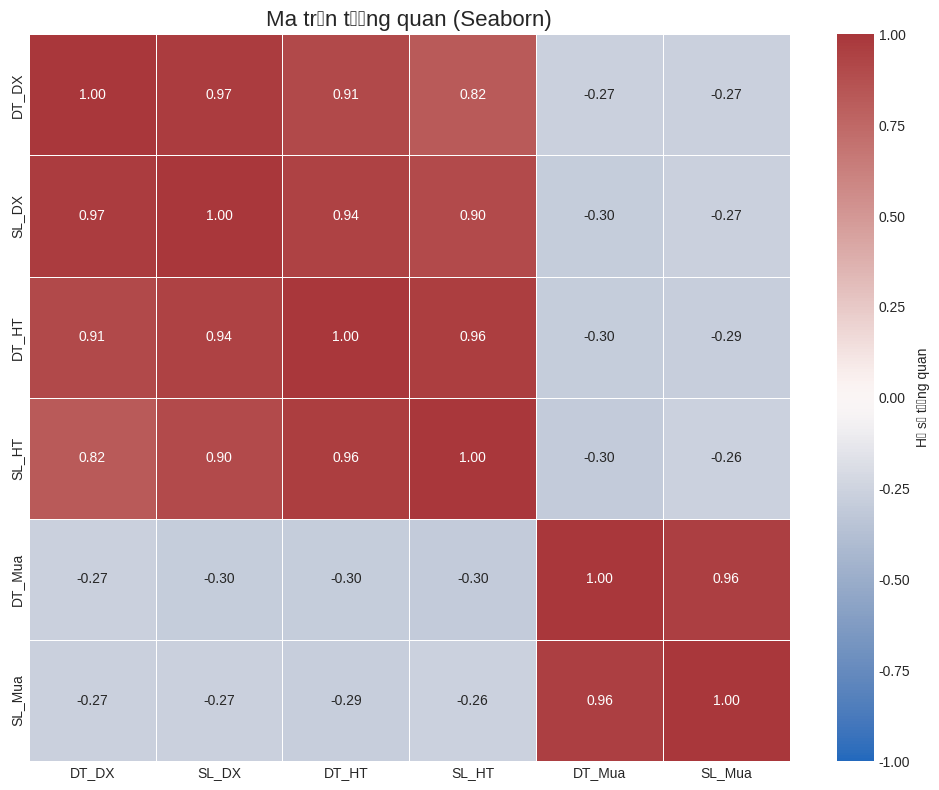

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Tải dữ liệu
file_path = "DBSCL_agriculture_1995_2024.csv"

try:
    df = pd.read_csv(file_path)

    # 2. Chọn các cột liên quan
    columns_of_interest = [
        'cultivated_area_winter_spring', 'rice_production_winter_spring',
        'cultivated_area_summer_autumn', 'rice_production_summer_autumn',
        'cultivated_area_main_season', 'rice_production_main_season'
    ]
    df_corr = df[columns_of_interest]

    # 3. Đổi tên cột để dễ đọc hơn trên biểu đồ
    rename_map = {
        'cultivated_area_winter_spring': 'DT_DX', # Diện tích Đông Xuân
        'rice_production_winter_spring': 'SL_DX', # Sản lượng Đông Xuân
        'cultivated_area_summer_autumn': 'DT_HT', # Diện tích Hè Thu
        'rice_production_summer_autumn': 'SL_HT', # Sản lượng Hè Thu
        'cultivated_area_main_season': 'DT_Mua',  # Diện tích Vụ Mùa
        'rice_production_main_season': 'SL_Mua'   # Sản lượng Vụ Mùa
    }
    df_corr = df_corr.rename(columns=rename_map)

    # 4. Tính toán ma trận tương quan
    corr_matrix = df_corr.corr()

    # 5. Vẽ biểu đồ
    # Thiết lập kích thước biểu đồ (rộng 10, cao 8)
    plt.figure(figsize=(10, 8))

    # Sử dụng heatmap của seaborn
    sns.heatmap(
        corr_matrix,
        annot=True,       # Hiển thị giá trị (hệ số tương quan)
        fmt=".2f",        # Định dạng số (2 chữ số thập phân)
        cmap="vlag",      # Chọn thang màu (xanh-trắng-đỏ)
        vmin=-1,          # Giá trị nhỏ nhất của thang màu
        vmax=1,           # Giá trị lớn nhất của thang màu
        center=0,         # Căn giữa thang màu tại 0
        linewidths=.5,    # Thêm đường viền mỏng giữa các ô
        cbar_kws={'label': 'Hệ số tương quan'} # Thêm nhãn cho thanh màu
    )

    # Thêm tiêu đề
    plt.title('Ma trận tương quan (Seaborn)', fontsize=16)

    # 6. Hiển thị biểu đồ
    # Lệnh này sẽ mở một cửa sổ mới hiển thị biểu đồ
    plt.tight_layout() # Tự động điều chỉnh layout
    plt.show()

except FileNotFoundError:
    print(f"Lỗi: Không tìm thấy tệp '{file_path}'.")
    print("Vui lòng đảm bảo tệp CSV nằm cùng thư mục với mã của bạn.")
except Exception as e:
    print(f"Đã xảy ra lỗi: {e}")

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib as mpl
import matplotlib.font_manager as fm

# --- CẤU HÌNH FONT (Giữ nguyên) ---
try:
    mpl.rcParams['font.family'] = 'DejaVu Sans'
    mpl.rcParams['axes.unicode_minus'] = False
    print("Đã cấu hình sử dụng font DejaVu Sans.")
except Exception as e:
    print(f"Lỗi khi cấu hình font DejaVu Sans: {e}. Đang thử dùng font mặc định...")

plt.style.use('seaborn-v0_8-whitegrid')

# --- 1. Load Data (Cả 2 file) ---
weather_file = 'DBSCL_weather_summary_by_season_FULL.xlsx'
agri_file = 'DBSCL_agriculture_1995_2024.csv'

try:
    # Tải dữ liệu thời tiết
    df_summary = pd.read_excel(weather_file, engine='openpyxl')
    print(f"Đã tải thành công file thời tiết: {weather_file}")

    # Tải dữ liệu nông nghiệp
    df_agri = pd.read_csv(agri_file)
    print(f"Đã tải thành công file nông nghiệp: {agri_file}")

except FileNotFoundError as e:
    print(f"Lỗi: Không tìm thấy tệp {e.filename}")
    exit()
except Exception as e:
    print(f"Lỗi khi đọc tệp: {e}")
    exit()

# --- 2. Xử lý Dữ liệu Nông nghiệp (Tính tổng sản lượng ĐBSCL) ---
print("Đang tính tổng sản lượng lúa theo năm và vụ...")
try:
    # Nhóm theo năm, tính TỔNG sản lượng của toàn ĐBSCL
    df_agri_agg = df_agri.groupby('year').agg(
        SL_DX=('rice_production_winter_spring', 'sum'),
        SL_HT=('rice_production_summer_autumn', 'sum'),
        SL_Mua=('rice_production_main_season', 'sum')
    ).reset_index()

    # Chuyển từ dạng "wide" sang "long" để vẽ biểu đồ
    df_agri_long = df_agri_agg.melt(
        id_vars='year',
        value_vars=['SL_DX', 'SL_HT', 'SL_Mua'],
        var_name='season_code',
        value_name='total_production'
    )

    # Map tên vụ để đồng nhất
    season_map = {'SL_DX': 'Vụ Đông Xuân', 'SL_HT': 'Vụ Hè Thu', 'SL_Mua': 'Vụ Mùa'}
    df_agri_long['season'] = df_agri_long['season_code'].map(season_map)
    print("Tính tổng sản lượng thành công.")

except Exception as e:
    print(f"Lỗi khi xử lý dữ liệu nông nghiệp: {e}")
    exit()

# --- 3. Xử lý Dữ liệu Thời tiết (Tính trung bình ĐBSCL - Giống code của bạn) ---
print("Đang tính giá trị trung bình thời tiết cho toàn ĐBSCL...")
try:
    # Nhóm theo năm và vụ, tính trung bình
    df_avg_all_seasons = df_summary.groupby(['year', 'season']).agg(
        avg_mean_temp=('mean_temp', 'mean'),
        avg_total_precipitation=('total_precipitation', 'mean'),
        avg_total_et0=('total_et0', 'mean'),
        avg_sunny_day_rate=('sunny_day_rate', 'mean')
    ).reset_index()

    # Kiểm tra tên các vụ trong file weather
    available_seasons = df_avg_all_seasons['season'].unique()
    print(f"Các vụ có trong file thời tiết: {available_seasons}")

    # Lọc dữ liệu cho Vụ Đông Xuân
    df_ws_weather = df_avg_all_seasons[df_avg_all_seasons['season'] == 'Vụ Đông Xuân'].copy()
    df_ws_weather.set_index('year', inplace=True)

    print("Tính trung bình thời tiết và lọc Vụ Đông Xuân thành công.")
except Exception as e:
    print(f"Lỗi trong quá trình tính trung bình thời tiết: {e}")
    exit()

# --- 4. Plot 1: Biểu đồ Cột Sản lượng các Vụ ---
print("Đang vẽ biểu đồ Cột Sản lượng...")
try:
    # Pivot dữ liệu nông nghiệp để vẽ grouped bar
    df_agri_pivot = df_agri_long.pivot(index='year', columns='season', values='total_production')

    # Sắp xếp lại cột để đảm bảo thứ tự
    df_agri_pivot = df_agri_pivot[['Vụ Đông Xuân', 'Vụ Hè Thu', 'Vụ Mùa']]

    # Vẽ biểu đồ cột
    ax = df_agri_pivot.plot(
        kind='bar',
        figsize=(15, 8),
        width=0.8, # Độ rộng của nhóm 3 cột
        colormap='viridis' # Bảng màu
    )

    plt.title('Tổng Sản lượng lúa các Vụ (Toàn ĐBSCL, 1995-2024)', fontsize=16)
    plt.ylabel('Sản lượng (nghìn tấn)', fontsize=12)
    plt.xlabel('Năm', fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(fontsize=10)
    plt.legend(title='Vụ', fontsize=11)

    # Định dạng trục Y cho dễ đọc (ví dụ: 10,000,000)
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: format(int(x), ',')))

    plt.tight_layout()
    plt.savefig('production_by_season_bar.png')
    plt.close()
    print(f"Đã lưu biểu đồ sản lượng: production_by_season_bar.png")

except Exception as e:
    print(f"Lỗi khi vẽ biểu đồ Cột: {e}")

# --- 5. Plot 2: Biểu đồ Line Thời tiết (Chỉ Vụ Đông Xuân) ---
print("Đang vẽ biểu đồ Line các yếu tố thời tiết Vụ Đông Xuân...")
try:
    # Tạo 4 subplots (4 hàng, 1 cột), chia sẻ chung trục X (năm)
    fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(14, 12), sharex=True)

    fig.suptitle('Xu hướng các Yếu tố Thời tiết Vụ Đông Xuân (ĐBSCL, 1995-2024)', fontsize=16)

    # Biến để map
    variables_to_plot_ws = {
        'avg_mean_temp': ('Nhiệt độ Trung bình (°C)', 'red', axes[0]),
        'avg_total_precipitation': ('Tổng Lượng mưa Trung bình (mm)', 'blue', axes[1]),
        'avg_total_et0': ('Tổng Lượng Bốc hơi TB (mm)', 'green', axes[2]),
        'avg_sunny_day_rate': ('Tỷ lệ Ngày nắng Trung bình (%)', 'orange', axes[3])
    }

    for col_name, (ylabel, color, ax) in variables_to_plot_ws.items():
        ax.plot(df_ws_weather.index, df_ws_weather[col_name], color=color, marker='o', markersize=4)
        ax.set_ylabel(ylabel, fontsize=11)
        ax.grid(True)
        ax.tick_params(axis='y', labelsize=10)

    # Cấu hình trục X chung (chỉ hiển thị ở biểu đồ cuối)
    plt.xlabel('Năm', fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    # Đặt mốc trục X 5 năm một lần
    axes[3].xaxis.set_major_locator(mticker.MultipleLocator(5))

    plt.tight_layout(rect=[0, 0.03, 1, 0.96]) # Điều chỉnh layout để vừa vặn với super-title
    plt.savefig('weather_trends_dong_xuan.png')
    plt.close()
    print(f"Đã lưu biểu đồ thời tiết Vụ Đông Xuân: weather_trends_dong_xuan.png")

except Exception as e:
    print(f"Lỗi khi vẽ biểu đồ Line: {e}")

print("\n--- HOÀN THÀNH ---")

Đã cấu hình sử dụng font DejaVu Sans.
Đã tải thành công file thời tiết: DBSCL_weather_summary_by_season_FULL.xlsx
Đã tải thành công file nông nghiệp: DBSCL_agriculture_1995_2024.csv
Đang tính tổng sản lượng lúa theo năm và vụ...
Tính tổng sản lượng thành công.
Đang tính giá trị trung bình thời tiết cho toàn ĐBSCL...
Các vụ có trong file thời tiết: ['main_season' 'summer_autumn' 'winter_spring']
Tính trung bình thời tiết và lọc Vụ Đông Xuân thành công.
Đang vẽ biểu đồ Cột Sản lượng...


/tmp/ipython-input-129988207.py:115: UserWarning: Glyph 7843 (\N{LATIN SMALL LETTER A WITH HOOK ABOVE}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipython-input-129988207.py:115: UserWarning: Glyph 432 (\N{LATIN SMALL LETTER U WITH HORN}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipython-input-129988207.py:115: UserWarning: Glyph 7907 (\N{LATIN SMALL LETTER O WITH HORN AND DOT BELOW}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipython-input-129988207.py:115: UserWarning: Glyph 7845 (\N{LATIN SMALL LETTER A WITH CIRCUMFLEX AND ACUTE}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipython-input-129988207.py:115: UserWarning: Glyph 7893 (\N{LATIN SMALL LETTER O WITH CIRCUMFLEX AND HOOK ABOVE}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipython-input-129988207.py:115: UserWarning: Glyph 7909 (\N{LATIN SMALL LETTER U WITH DOT BELOW}) missing from font(s) Liberation Sans.
  plt.tight_layout

Đã lưu biểu đồ sản lượng: production_by_season_bar.png
Đang vẽ biểu đồ Line các yếu tố thời tiết Vụ Đông Xuân...


/tmp/ipython-input-129988207.py:151: UserWarning: Glyph 7879 (\N{LATIN SMALL LETTER E WITH CIRCUMFLEX AND DOT BELOW}) missing from font(s) Liberation Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.96]) # Điều chỉnh layout để vừa vặn với super-title
/tmp/ipython-input-129988207.py:151: UserWarning: Glyph 7897 (\N{LATIN SMALL LETTER O WITH CIRCUMFLEX AND DOT BELOW}) missing from font(s) Liberation Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.96]) # Điều chỉnh layout để vừa vặn với super-title
/tmp/ipython-input-129988207.py:151: UserWarning: Glyph 7893 (\N{LATIN SMALL LETTER O WITH CIRCUMFLEX AND HOOK ABOVE}) missing from font(s) Liberation Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.96]) # Điều chỉnh layout để vừa vặn với super-title
/tmp/ipython-input-129988207.py:151: UserWarning: Glyph 432 (\N{LATIN SMALL LETTER U WITH HORN}) missing from font(s) Liberation Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.96]) # Điều chỉnh layout để vừa vặn với super-title
/tmp/ipython-input-129988207.py:

Đã lưu biểu đồ thời tiết Vụ Đông Xuân: weather_trends_dong_xuan.png

--- HOÀN THÀNH ---
